# Case study: Reaction times of Schizophrenics

## Objectives and takeaways
1. Take a real-world experiment, write the model.
2. Write a Metropolis sampler, including the proposal distribution.
3. Perform inference using your sampler

## Experiment

We shall work with the experiment published in Belin and Rubin [1] in 1995 that analyzed reaction times to visual stimuli in Schizophrenia.

A total of 17 volunteers performed 30 repetitions of a visual task and their reaction time was measured in milliseconds. There were 6 schizophrenics and 11 healthy volunteers.

Note that in the work [1], the authors do not use a Bayesian approach for estimation but apply an EM procedure.  The priors that we define in this work must therefore be our construction.

Below is the original data from the experiment, available [here](http://www.stat.columbia.edu/~gelman/book/data/schiz.asc).

In [1]:
orig_data = """
312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282 350 328 332 308 292 258 340 242 306 328 294 272
354 346 384 342 302 312 322 376 306 402 320 298 308 414 304 422 388 422 426 338 332 426 478 372 392 374 430 388 354 368
256 284 320 274 324 268 370 430 314 312 362 256 342 388 302 366 298 396 274 226 328 274 258 220 236 272 322 284 274 356
260 294 306 292 264 290 272 268 344 362 330 280 354 320 334 276 418 288 338 350 350 324 286 322 280 256 218 256 220 356
204 272 250 260 314 308 246 236 208 268 272 264 308 236 238 350 272 252 252 236 306 238 350 206 260 280 274 318 268 210
590 312 286 310 778 364 318 316 316 298 344 262 274 330 312 310 376 326 346 334 282 292 282 300 290 302 300 306 294 444
308 364 374 278 366 310 358 380 294 334 302 250 542 340 352 322 372 348 460 322 374 370 334 360 318 356 338 346 462 510
244 240 278 262 266 254 240 244 226 266 294 250 284 260 418 280 294 216 308 324 264 232 294 236 226 234 274 258 208 380
232 262 230 222 210 284 232 228 264 246 264 316 260 266 304 268 384 234 308 266 294 254 222 262 278 290 208 232 206 206
318 324 282 364 286 342 306 302 280 306 256 334 332 336 360 344 480 310 336 314 392 284 292 280 320 322 286 406 352 324
240 292 350 254 396 430 260 320 298 312 290 248 276 364 318 434 400 382 318 298 298 248 250 234 280 306 282 234 424 244

276 272 264 258 278 286 314 340 334 364 286 344 312 380 262 324 310 260 280 262 364 316 270 286 326 302 300 302 344 290
374 466 432 376 360 454 478 382 524 410 520 470 514 354 434 380 416 384 462 386 404 362 420 360 390 356 550 372 386 396
594 1014 1586 1344 610 838 772 264 748 1076 446 314 304 1680 1700 334 256 422 302 296 354 322 276 382 502 428 544 286 650 432
402 466 296 348 680 702 500 500 576 624 406 378 586 826 298 882 564 656 716 380 448 506 1714 748 510 810 984 458 390 642
620 714 414 358 460 598 324 442 372 410 998 636 968 490 696 560 562 720 618 456 502 974 1032 470 462 798 716 300 586 574
454 388 344 226 562 766 502 432 608 516 500 796 542 458 448 404 372 524 400 366 374 350 1154 558 440 348 400 460 514 450"""

In [2]:
import numpy as np

# the first 11 lines are from controls, the last 6 from schizophrenics
def parse_data():
    rts, idx = [], 0
    for line in orig_data.split('\n'):
        if len(line) == 0: continue
        cat = 0 if idx < 11 else 1
        tokens = line.split(' ')
        rts.append(list(map(int, line.split(' '))))
    return np.array(rts)

reaction_times = parse_data()

In [3]:
Np, Nt = reaction_times.shape
print('Data shows %d patients, %d trials per patient' % (Np, Nt))

Data shows 17 patients, 30 trials per patient


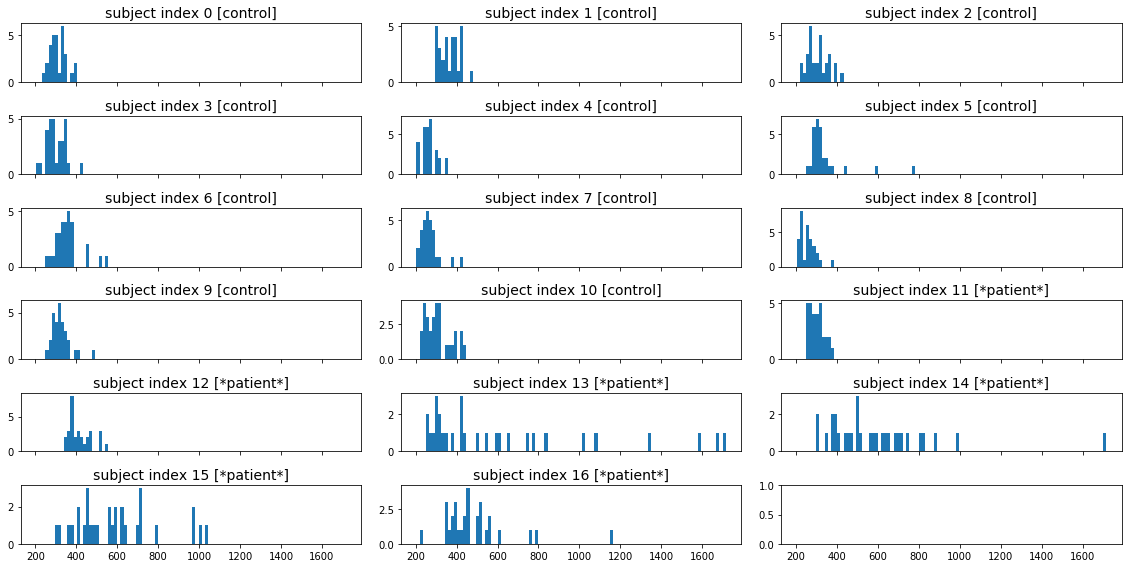

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

_, axes = plt.subplots(6, 3, figsize=(16, 8), sharex=True)
bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)
axes = axes.flatten()
for isbj in range(Np):
    axes[isbj].hist(reaction_times[isbj, :], bins)
    axes[isbj].set_title('subject index %d [%s]' %(isbj, 'control' if isbj < 11 else '*patient*'), fontsize=14)
plt.tight_layout();

### Data description
Patients are stored in rows. For example data in line ```rts[0,:]``` shows reaction times in milliseconds for the first control group participant.

In [5]:
print(reaction_times[0,:])

[312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282
 350 328 332 308 292 258 340 242 306 328 294 272]


### Model structure
Below we discuss model similar to model number 4 from Belin and Rubin [1], their richest model. The other models are not discussed in this notebook.

In the following, we will use the subscript $i \in \{1, 2, ..., 17\}$ to denote participants and $j \in \{1, 2, ..., 30\}$ to denote trials, so for example $Y_{i,j}$ denotes observed reaction time for patient $i$ and trial $j$.

It is assumed that there is a mean reaction time $\mu$ and standard deviation $\sigma_1$ in the control group but each participant in the study can have a slightly different mean reaction time $\alpha_i$. Schizophrenic participants behave like the control group except in specific trials, where they exhibit an attention deficit that causes their reaction time to be increased.  The (unobserved) variable $Z_{i,j} \in \{0,1\}$ denotes whether the attention deficit was present $Z_{i,j}=1$ or absent $Z_{i,j}=0$ in trial $j$ for patient $i$. The proportion of trials $\lambda_i$ where the deficit manifests varies among patients.

We may formalize the model for the control group as follows:

$$Y_{i,j} \sim {\cal N}(\alpha_i, \sigma_1^2)$$

and for the schizophrenia group as

$$Y_{i,j} \sim {\cal N}(\alpha_i, \sigma_1^2),$$

if the trial had no attention deficit present (so exactly the same as control group) and

$$Y_{i,j} \sim {\cal N}(\alpha_i + \tau, \sigma_2^2),$$

if there was an attention deficit.  Note the different standard deviation used to model the reaction time under attention deficit.  In the model below, we use $Z_{i,j}$ to keep track of which mode is active in the trials performed by schizophrenic patients.  We additionally posit that 

$$\begin{array}{rcl}
\lambda_i &\sim& \text{Beta}(1,2) \\
Z_{i,j} &\sim& \text{Bernoulli}(\lambda), \\
\mu &\sim& {\cal N}(400, 100)\\
\alpha_i &\sim& {\cal N}(\mu, 50), \\
\tau &\sim& \text{HalfNormal}(50), \\
\sigma_1 &\sim& \text{HalfNormal}(100), \\
\sigma_2 &\sim& \text{HalfNormal}(100). \\
\end{array}$$

### Structure of solution
1. Select priors for the problem (see below).
2. Write down the structure of the model, write the ```log_prior``` and ```log_likelihood``` functions.
3. Write a proposal distribution, function ```proposal``` to suggest a new state from current state.
4. Write (or modify, from notebook 3f) the Metropolis sampler.
5. Sample outputs and evaluate.

We see that patients 13, 14 and 15 have the highest attention deficit proportion, which seems to correspond to the initial data plots well.

# Your turn!
Now let's work on writing our own sampler.  While ```PyMC3``` uses a NUTS sampler plus Gibbs sampling for the latent variables $Z_{i,j}$, we will build the entire system using Metropolis and compare our results.

### Structure of state
Although as much freedom should be provided to write the code, there is a recommendation below on how to structure the state variable as a dictionary because it helps to improve the readability of the code.

In [6]:
import numpy.random as nr

# setup the initial point
lambda_initial = 0.5

# here's a nice initial point :)
v_init = { 'mu' : np.mean(reaction_times),
           'delta_alphas': nr.randn(Np) * 50,
           'tau': 50,
           'sigma_ctrl': 50,
           'sigma_pat': 200,
           'lambdas' : np.ones(6,) * lambda_initial,
           'Z': np.where(nr.uniform(size=(6,Nt)) < lambda_initial, np.ones((6,Nt)), np.zeros((6,Nt)))
         }

v_init

{'Z': array([[0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
         1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.]]),
 'delta_alphas': array([-28.85068178, -11.75175899,  67.26071823, -20.76909942,
         22.44023839, -60.1351713 ,  50.21972784, -13.07762911,
          6.778

## Prior & likelihood
Below, we need to encode the prior and likelihood (both in log space) according to the model specification.

In [7]:
def log_normal(x, mu, sd):
    return -np.log(sd)-0.5*(x-mu)**2/sd**2

def log_halfnorm(x, sd):
    # note assumes that x is non-negative!
    return -np.log(sd)-0.5*(x/sd)**2


def log_prior(v):
    mu, dalphas, tau = v['mu'], v['delta_alphas'], v['tau'], 
    lambdas, Z, sigma_ctrl, sigma_pat = v['lambdas'], v['Z'], v['sigma_ctrl'], v['sigma_pat']
    
    # lambdas being U[0,1]-distributed don't add anything to log-normal
    logp = log_normal(mu, 400, 100) \
        + np.sum(log_normal(dalphas, 0, 50)) \
        + log_halfnorm(tau, 100) \
        + log_halfnorm(sigma_ctrl, 100) \
        + log_halfnorm(sigma_pat, 100)

    # contribution from Z terms
    logp += np.sum(np.log(Z * lambdas[:,np.newaxis] + (1-Z) * (1-lambdas[:,np.newaxis])))
    
    return logp

In [8]:
def log_likelihood(v, rts):    
    ll = 0.0
    tau, sigma_ctrl, sigma_pat = v['tau'], v['sigma_ctrl'], v['sigma_pat']
    mu, dalphas, Z = v['mu'], v['delta_alphas'], v['Z']
    
    # control group
    ll = np.sum(log_normal(rts[:11,:] - (mu + dalphas[:11,np.newaxis]), 0, sigma_ctrl))
    
    # patients
    ll += np.sum(log_normal(rts[11:,:], mu + dalphas[11:,np.newaxis] + Z*tau, Z*sigma_pat + (1-Z)*sigma_ctrl))
    
    return ll


def model_log_posterior_unnorm(v, rts):
    return log_prior(v) + log_likelihood(v, rts)

In [9]:
log_prior(v_init), log_likelihood(v_init, reaction_times), model_log_posterior_unnorm(v_init, reaction_times)

(-215.74516635848323, -4445.0875750005, -4660.832741358983)

### The Proposal

In [10]:
def log_norm_proposal_scalar(x, sd):
    return np.exp(np.log(x) + np.random.randn() * sd)

def reflection_proposal(x, sd):
    x_new = np.mod(x + np.random.randn(*x.shape) * sd, 2.)
    return np.where(x_new > 1., 2. - x_new, x_new)

def propose(v, accept_ratio=None):
    v_new= {}
    move_prob = 0.33
    
    # propose new mu
    v_new['mu'] = v['mu'] + np.random.randn()*2. * (np.random.uniform() < move_prob)

    # trick 1. only change a few alphas at a time
    v_new['delta_alphas'] = np.where(np.random.uniform(size=Np) < move_prob,
                                     v['delta_alphas'] + np.random.randn(Np,)*2.,
                                     v['delta_alphas'])
    
    # trick 2. jumping around half-normals with uniform multiplicative factor
    v_new['tau'] = log_norm_proposal_scalar(v['tau'], 0.5) if np.random.uniform() < move_prob else v['tau']
    v_new['sigma_ctrl'] = log_norm_proposal_scalar(v['sigma_ctrl'], 0.2) if np.random.uniform() < move_prob else v['sigma_ctrl']
    v_new['sigma_pat'] = log_norm_proposal_scalar(v['sigma_pat'], 0.2) if np.random.uniform() < move_prob else v['sigma_pat']
    
    # trick 3. make jump in log-odds transformed space for lambdas
    lams_old = v['lambdas']
    v_new['lambdas'] = np.where(np.random.uniform(size=6) < move_prob, reflection_proposal(lams_old, 0.1), lams_old)
    
    # sample the new Z_ij parameters but only a few at a time
    Z = v['Z']
    mask = np.random.uniform(size=(6,Nt)) < 1./90
    v_new['Z'] = mask * (1-Z) + (1-mask) * Z
    
    return v_new

## The Sampler

In [11]:
def metropolis(v_init, log_posterior, n, status_period=None):
    v, logp = v_init, log_posterior(v_init)
    states, states_logp = [v_init], [logp]
    was_accept = []
    
    if status_period is None:
        status_period = n // 10
    
    for i in range(1, n):
        
        # every 500 steps, invoke adaptation
        accept_probability = None
        if i % 500 == 0:
            accept_probability = float(np.sum(was_accept[i-500:i])/500)
        
        # make a Metropolis proposal
        v_new = propose(v, accept_probability)
        logp_new = log_posterior(v_new)
        
        # draw uniform number
        u = np.random.uniform()
        if logp_new - logp > np.log(u):
            v, logp = v_new, logp_new
            states.append(v_new)
            states_logp.append(logp_new)
            was_accept.append(1)
        else:
            # this is different from Monte Carlo rejection sampler
            # if we reject a new sample we 're-sample' the current state
            states.append(v)
            states_logp.append(logp)
            was_accept.append(0)
            
        if i % status_period == 0:
            print('Stats @ %d: accept_ratio=%g avg_logp=%g' % (i, float(np.sum(was_accept[i-status_period:i]))/status_period, np.mean(states_logp[i-status_period:i])))
            
    return states, float(np.sum(was_accept)) / n, was_accept

In [12]:
trace, accept_ratio, proposals = metropolis(v_init, lambda v: model_log_posterior_unnorm(v, reaction_times), 200000, 10000)
print('DONE.')

Stats @ 10000: accept_ratio=0.0719 avg_logp=-2691.26
Stats @ 20000: accept_ratio=0.0443 avg_logp=-2620.31
Stats @ 30000: accept_ratio=0.0379 avg_logp=-2619.93
Stats @ 40000: accept_ratio=0.04 avg_logp=-2617.68
Stats @ 50000: accept_ratio=0.0428 avg_logp=-2616.8
Stats @ 60000: accept_ratio=0.0468 avg_logp=-2613.99
Stats @ 70000: accept_ratio=0.0435 avg_logp=-2606.04
Stats @ 80000: accept_ratio=0.0394 avg_logp=-2600.67
Stats @ 90000: accept_ratio=0.0373 avg_logp=-2604.09
Stats @ 100000: accept_ratio=0.0367 avg_logp=-2600.68
Stats @ 110000: accept_ratio=0.039 avg_logp=-2602.56
Stats @ 120000: accept_ratio=0.0405 avg_logp=-2607.76
Stats @ 130000: accept_ratio=0.0377 avg_logp=-2602.35
Stats @ 140000: accept_ratio=0.0356 avg_logp=-2601.2
Stats @ 150000: accept_ratio=0.0377 avg_logp=-2607.37
Stats @ 160000: accept_ratio=0.0459 avg_logp=-2612.19
Stats @ 170000: accept_ratio=0.0405 avg_logp=-2606.55
Stats @ 180000: accept_ratio=0.0457 avg_logp=-2614.98
Stats @ 190000: accept_ratio=0.0454 avg_lo

In [13]:
taus = np.array([v['tau'] for v in trace])
sigmas_ctrl = np.array([v['sigma_ctrl'] for v in trace])
sigmas_pat = np.array([v['sigma_pat'] for v in trace])
lambdas = np.vstack([v['lambdas'] for v in trace])
mus = np.array([v['mu'] for v in trace])
alphas = mus[:,np.newaxis] + np.vstack([v['delta_alphas'] for v in trace])
Zs = np.array([v['Z'] for v in trace])

In [14]:
# show table
for i,(mn,sd) in enumerate(zip(np.mean(lambdas, axis=0), np.std(lambdas, axis=0))):
    print('lambda_%d  : %g +- %g' % (i, mn, sd))

print('mu        : %g +- %g' % (np.mean(mus), np.std(mus)))
print('tau       : %g +- %g' % (np.mean(taus), np.std(taus)))

print('sigma_ctrl: %g +- %g' % (np.mean(sigmas_ctrl), np.std(sigmas_ctrl)))
print('sigma_pat : %g +- %g' % (np.mean(sigmas_pat), np.std(sigmas_pat)))

lambda_0  : 0.0380562 +- 0.0421801
lambda_1  : 0.0557953 +- 0.0681659
lambda_2  : 0.605817 +- 0.106194
lambda_3  : 0.729441 +- 0.104779
lambda_4  : 0.884503 +- 0.0926938
lambda_5  : 0.361525 +- 0.203608
mu        : 323.425 +- 11.4054
tau       : 284.849 +- 38.1489
sigma_ctrl: 55.6897 +- 4.01699
sigma_pat : 302.766 +- 23.9436


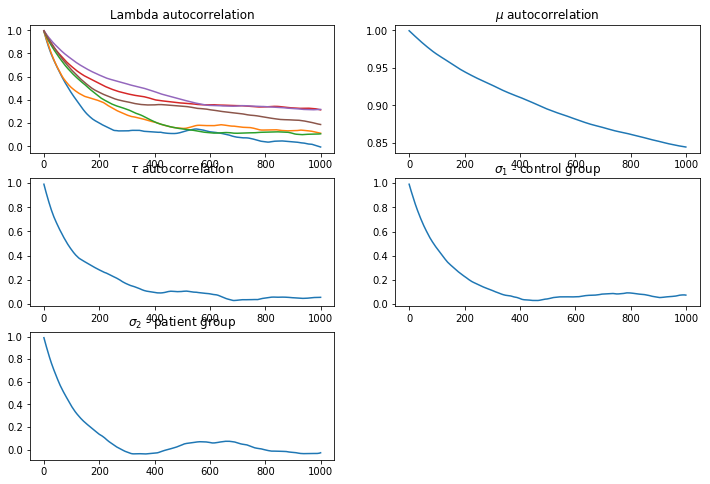

In [15]:
def compute_acorr(series):
    s = series - np.mean(series)
    norm = np.sum(s**2)
    return np.correlate(s, s, mode='full')[len(s):] / norm

plt.figure(figsize=(12, 8))
plt.subplot(3,2,1)
for i in range(6):
    plt.plot(compute_acorr(lambdas[-50000:,i])[:1000])
plt.title('Lambda autocorrelation')

plt.subplot(3,2,2)
plt.plot(compute_acorr(mus[-50000:])[:1000])
plt.title('$\\mu$ autocorrelation')

plt.subplot(3,2,3)
plt.plot(compute_acorr(taus[-50000:])[:1000])
plt.title('$\\tau$ autocorrelation')

plt.subplot(3,2,4)
plt.plot(compute_acorr(sigmas_ctrl[-50000:])[:1000])
plt.title('$\\sigma_1$ - control group')

plt.subplot(3,2,5)
plt.plot(compute_acorr(sigmas_pat[-50000:])[:1000])
plt.title('$\\sigma_2$ - patient group');

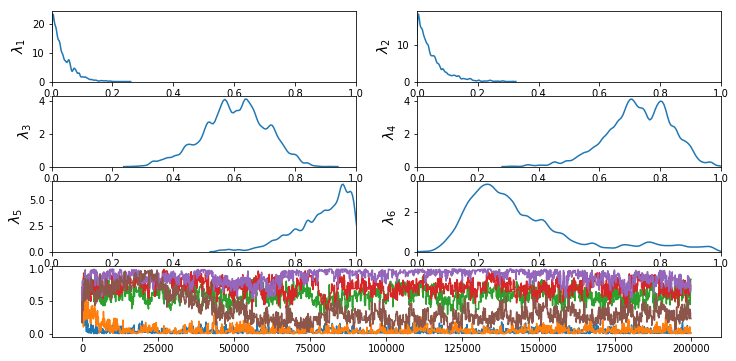

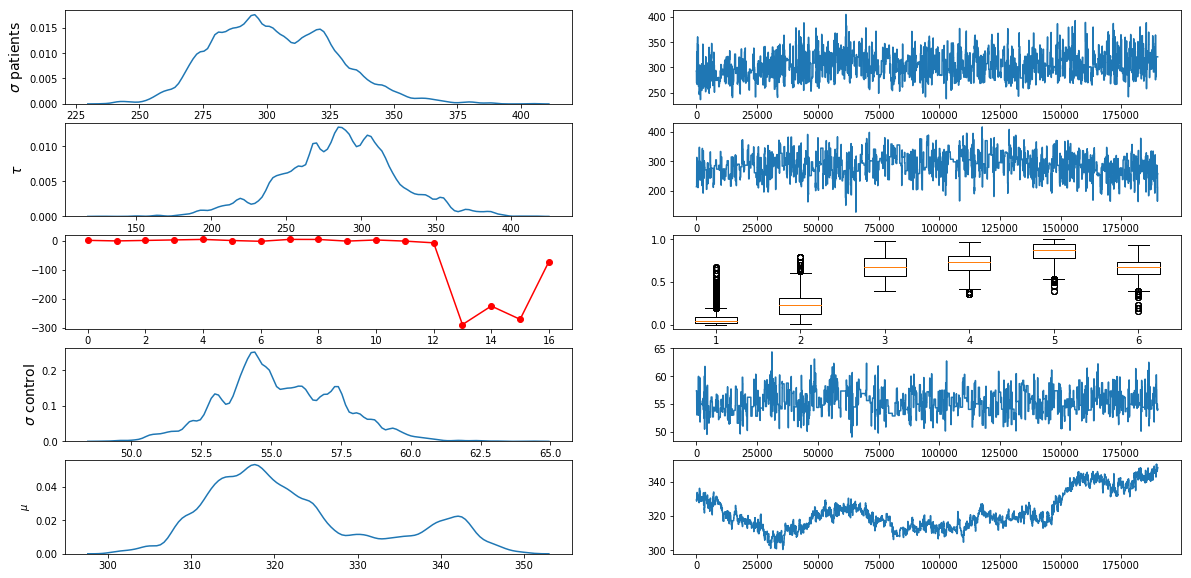

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#burn_in = 50000
burn_in = 10000

plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(4,2,k+1)
    sns.kdeplot(lambdas[burn_in:,k])
    plt.ylabel('$\lambda_%d$' % (k+1), fontsize=14)
    plt.xlim([0,1])
plt.subplot(4,1,4)
plt.plot(lambdas)

plt.figure(figsize=(20,10))
plt.subplot(5,2,1)
sns.kdeplot(sigmas_pat[burn_in:])
plt.ylabel('$\sigma$ patients', fontsize=14)
plt.subplot(5,2,2)
plt.plot(sigmas_pat[burn_in:])

plt.subplot(5,2,3)
sns.kdeplot(taus[burn_in:])
plt.ylabel('$\\tau$', fontsize=14)
plt.subplot(5,2,4)
plt.plot(taus[burn_in:])

plt.subplot(5,2,5)
plt.plot(np.mean(alphas[burn_in:,:], axis=0) - np.mean(reaction_times[:Np,:], axis=1), 'or-')

plt.subplot(5,2,6)
plt.boxplot(lambdas[:burn_in,:]);
np.mean(lambdas[:burn_in,:], axis=0)

plt.subplot(5,2,7)
sns.kdeplot(sigmas_ctrl[burn_in:])
plt.ylabel('$\sigma$ control', fontsize=14)
plt.subplot(5,2,8)
plt.plot(sigmas_ctrl[burn_in:])

plt.subplot(5,2,9)
sns.kdeplot(mus[burn_in:])
plt.ylabel('$\\mu$')
plt.subplot(5,2,10)
plt.plot(mus[burn_in:])

plt.show()

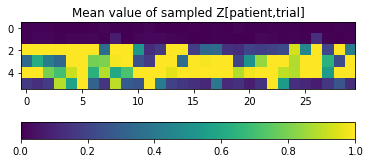

In [17]:
plt.imshow(Zs[burn_in:,:,:].mean(axis=0), cmap='viridis')
plt.title('Mean value of sampled Z[patient,trial]')
plt.colorbar(orientation="horizontal");

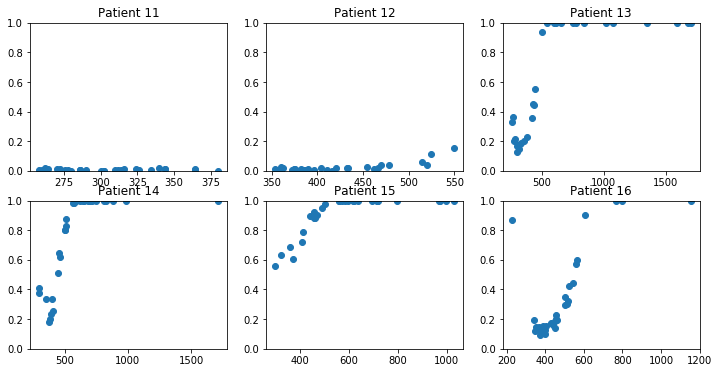

In [18]:
plt.figure(figsize=(12,6))
for k in range(6):
    plt.subplot(2,3,k+1)
    ts = reaction_times[k+11,:]
    Zs_k = np.mean(Zs[:,k,:], axis=0)
    plt.scatter(ts, Zs_k)
    plt.ylim([0,1])
    plt.title('Patient %d' % (k+11))

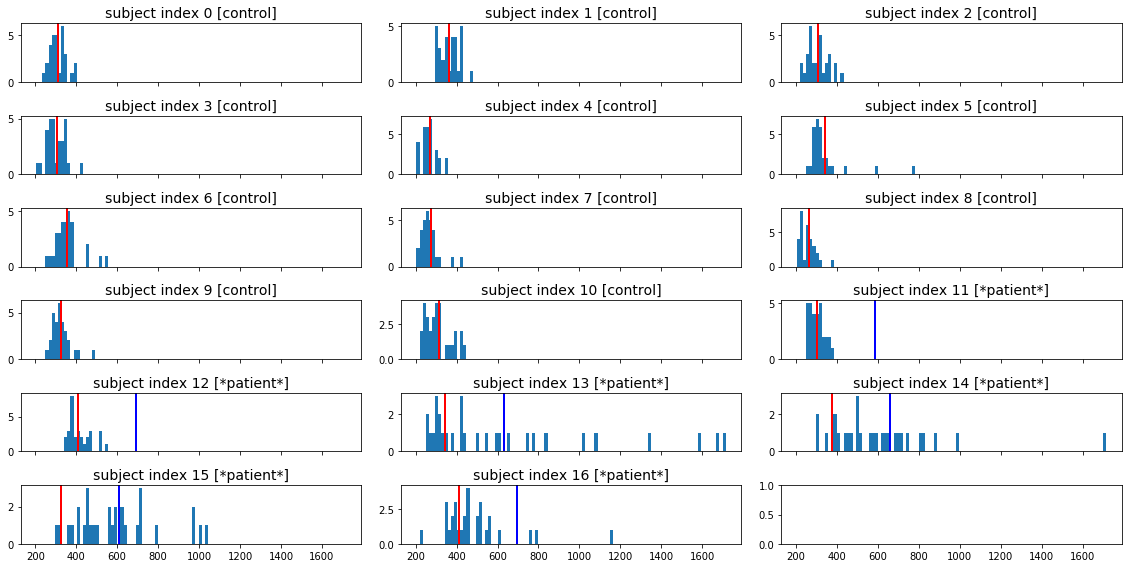

In [19]:
_, axes = plt.subplots(6, 3, figsize=(16, 8), sharex=True)
bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)
axes = axes.flatten()
for isbj in range(Np):
    axes[isbj].hist(reaction_times[isbj, :], bins)
    axes[isbj].axvline(np.mean(alphas[:,isbj]), linewidth=2, color='r')
    if isbj >= 11:
        axes[isbj].axvline(np.mean(alphas[:,isbj]+np.mean(taus)), linewidth=2, color='b')
    axes[isbj].set_title('subject index %d [%s]' %(isbj, 'control' if isbj < 11 else '*patient*'), fontsize=14)
plt.tight_layout();